# Lab 5: Resampling and Bootstrapping

## Due Saturday, May 20th at 11:59PM

Welcome to Lab 5! In this assignment, we'll develop a further understanding of parameter estimation and bootstrapping, which you can learn more about in [CIT 13](https://inferentialthinking.com/chapters/13/Estimation.html). The relevant lectures are Lectures 13, 18, and 19.

You should complete this entire lab so that all tests pass and submit it to Gradescope by 11:59PM on the due date.

In [1]:
# Imports
import numpy as np
import babypandas as bpd
import math

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)

import otter
grader = otter.Notebook()

from IPython.display import YouTubeVideo, IFrame

def show_bootstrapping_slides():
    src = "https://docs.google.com/presentation/d/e/2PACX-1vS_iYHJYXSVMMZ-YQVFwMEFR6EFN3FDSAvaMyUm-YJfLQgRMTHm3vI-wWJJ5999eFJq70nWp2hyItZg/embed?start=false&loop=false&delayms=3000"
    width = 600
    height = 320
    display(IFrame(src, width, height))
    
%reload_ext pandas_tutor

### Supplemental video on `for`-loops and when NOT to use them

We put together a video reviewing some of the ways to perform repetitive tasks (e.g. random sampling, performing operations to every element of a column) **without** using a `for`-loop. We'll also look at when exactly it is you do need a `for`-loop in this class (running an experiment many times). This is important, because using a `for`-loop when not necessary is a **bad** idea, as the resulting code is quite slow and hard to debug.

If you're feeling a little shaky on iteration and coding simulations, you may want to check it out!.

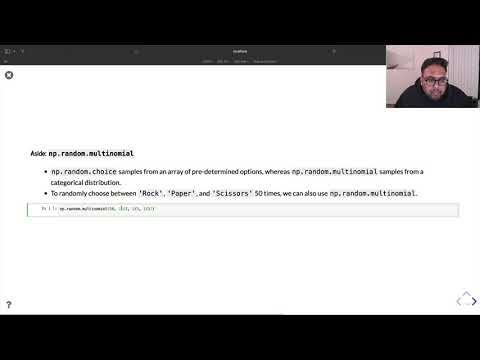

In [2]:
# Run this cell.
YouTubeVideo('BlczSBT80fU')

## 0. Percentiles 🅿️

Before we start, we need to introduce the concept of percentiles. Percentiles associate numbers in a dataset to their positions when the dataset is sorted in ascending order.

Given any sequence (i.e. list, array, or Series) of numerical values, imagine sorting the values in ascending order, to create a ranked sequence. Roughly speaking, the $p$th percentile of this sequence is the value that is $p$ percent of the way through the sequence. For example, the 10th percentile is only 10% of the way through (towards the beginning), the 50th percentile is halfway through (towards the middle), and the 90th percentile is 90% of the way through (towards the end).

There are many different ways to precisely define a percentile. In this class, we'll consider two different approaches. You should think of these as two separate, different ways to define a percentile. They don't always agree!

### The mathematical definition

> Let $p$ be a number between 0 and 100. The $p$th percentile of a collection is the smallest value in the collection that is *at least as large* as $p$% of all the values. 

With this definition, any percentile is always an element of the collection.

### The `numpy` definition

The `numpy` package provides a function `np.percentile` that takes two inputs: an array of numbers and a value `p`. It returns a number that represents the `p`th percentile of the array. You don't need to know how it calculates this value, but you should know:
- it's not always the same as the mathematical definition given above (though it is close), and
- it's not always an element of the array.

#### Question 0.1.

Say, you are in a class with 10 students and the grades of all students in the class are stored in the array `grades`. Your score is 84. 

In [3]:
#Median is 50th percentile, 100 percentile is max value, 80th percentile is 8th value in list

In [4]:
grades = np.array([56, 65, 67, 72, 74, 78, 78, 80, 84, 94])

Which of the following statements are true? Use the mathematical definition of percentile here. 

1. The highest score is the 100th percentile. 
2. Your score is more than the 80th percentile.
3. Your score is less than the 81st percentile.
4. Your score is the 86th percentile.
5. A score of 78 is the 50th percentile.

Assign `true_percentile` to a `list` containing the numbers of the true statements.

<!--
BEGIN QUESTION
name: q0_1
-->

In [5]:
true_percentile  = (1,2,4)
true_percentile

(1, 2, 4)

In [6]:
grader.check("q0_1")

q0_1 results: All test cases passed!

#### Question 0.2.
Use `np.percentile` to calculate the 50th percentile of the `grades` array and save the result as `p_50`.

In [7]:
p_50 = np.percentile(grades, 50)
p_50

76.0

In [8]:
grader.check("q0_2")

q0_2 results: All test cases passed!

#### Question 0.3.
Use `np.median` to calculate the median value of the `grades` array and save the result as `median_grade`.

**Manually** compare it to your answer from Question 0.2. Set the variable `same` to `True` if the two values are the same, and `False` if they are different. Do not use if/else for this question.

In [9]:
median_grade = np.median(grades)
print(median_grade)
same = (median_grade == p_50)

76.0


In [10]:
grader.check("q0_3")

q0_3 results: All test cases passed!

## 1. Allied Intelligence Preliminaries 🧠

Throughout this lab, we will study a statistical problem known as the [German tank problem](https://en.wikipedia.org/wiki/German_tank_problem).

In World War II, the Allies (led by the US, the UK, and the Soviet Union) wanted to know how many military tanks the Germans had produced. However, they didn't get to see every single tank produced by the Germans – rather, all they saw was a random **sample** of tanks.

To frame the problem more precisely, consider that tanks were given serial numbers ranging from 1 to `N`, where `N` was the total number of tanks produced. The Allies were trying to estimate `N`, a **population parameter**, using the serial numbers of the tanks in their sample. We will assume that the Allies' sample is a simple random sample of the population (drawn without replacement).

<br>

<center><img src='images/tank.jpg' width=400></center>

<br>


In this lab, given **just** a random sample of serial numbers, we'll estimate `N`, and then we'll use simulation to find out how accurate our estimate likely is, without ever looking at the whole population. This is an example of **statistical inference** – inferring something about a population using just the information in a sample.

**Question 1.1.** Is `N` a population parameter or a statistic?  If we compute a number using our random sample that's an estimate of `N`, is that a population parameter or a statistic?  Assign either 1, 2, 3, or 4 to the variable `preliminaries_q1` below. 
1. `N` is a population parameter.  An estimate of `N` from our random sample is a population parameter.
2. `N` is a population parameter.  An estimate of `N` from our random sample is a statistic.
3. `N` is a statistic.  An estimate of `N` from our random sample is a population parameter.
4. `N` is a statistic.  An estimate of `N` from our random sample is a statistic.

In [11]:
preliminaries_q1 = 2

In [12]:
grader.check("q1_1")

q1_1 results: All test cases passed!

To make the situation realistic, we're going to hide the true number of tanks from you.  You'll have access only to this random sample:

In [13]:
observations = bpd.read_csv("data/serial_numbers.csv")
num_observations = observations.shape[0]
observations

,serial_number
0,47
1,42
2,57
3,79
4,26
...,...
12,67
13,108
14,84
15,50


**Question 1.2.** Define a function named `plot_serial_numbers` that draws a histogram of any DataFrame of serial numbers.  It should take one argument, a DataFrame `df` with a single column column called `'serial_number'` (like `observations`).  It should plot a histogram of the values in the `'serial_number'` column **using bins of width 1** ranging from **1 to 200 (inclusive)** but return nothing.  Then, call that function to make a histogram of `observations`.

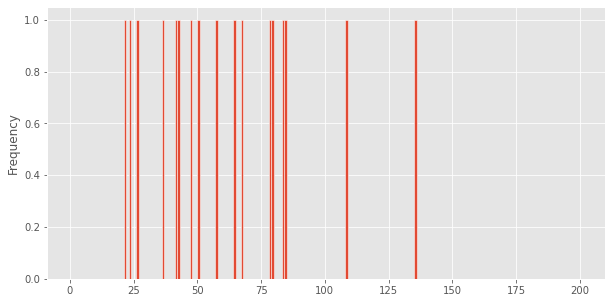

In [14]:
def plot_serial_numbers(df):
    df.get("serial_number").plot(kind = "hist", bins = range(1, 201), ec = "w")

# Call your function.
plot_serial_numbers(observations)

***Check your answer***: Your histogram should have bars that are all the same height and the x-axis should range from 0 to 200.

**Question 1.3.** Since we are trying to estimate the population max, `N`, a natural statistic to use is the sample **max**. In other words, we can estimate the total number of tanks as being the biggest serial number in our sample.

Below, write a function called `calculate_max_based_estimate` that computes that statistic on a given Series of serial numbers. It should take as its argument a Series of serial numbers and return their max.

After that, use it to compute an estimate of `N` using the serial numbers in `observations`. Call the estimate `max_based_estimate`.

In [15]:
def calculate_max_based_estimate(nums):
    return nums.max()

max_based_estimate = calculate_max_based_estimate(observations.get("serial_number"))
max_based_estimate

135

In [16]:
grader.check("q1_3")

q1_3 results: All test cases passed!

**Question 1.4.** Another way to estimate `N` is to take **twice the mean** of the serial numbers in our sample. Below, write a function called `calculate_mean_based_estimate` that computes that statistic. It should take as its argument a Series of serial numbers and return twice their mean.

After that, use it to compute an estimate of `N` using the serial numbers in `observations`. Call the estimate `mean_based_estimate`.

In [17]:
def calculate_mean_based_estimate(nums):
    return (2*(nums.mean()))

mean_based_estimate = calculate_mean_based_estimate(observations.get("serial_number"))
mean_based_estimate

122.47058823529412

In [18]:
grader.check("q1_4")

q1_4 results: All test cases passed!

**Question 1.5.** Look at the values of `max_based_estimate` and `mean_based_estimate` that we happened to get for our dataset:

In [19]:
max_based_estimate

135

In [20]:
mean_based_estimate

122.47058823529412

The value of `max_based_estimate` tells you something about `mean_based_estimate`.  Could our current `mean_based_estimate` possibly be equal to `N` (at least if we round it to the nearest integer)?  If not, is it definitely higher, definitely lower, or can we not tell?  Assign one of the choices (1-6) to the variable `preliminaries_q5` below. 
1. Yes, our `mean_based_estimate` for this sample could equal `N`.
2. No, our `mean_based_estimate` for this sample cannot be equal to `N`, it is definitely lower by roughly 3.
3. No, our `mean_based_estimate` for this sample cannot be equal to `N`, it is definitely lower by at least 12.
4. No, our `mean_based_estimate` for this sample cannot be equal to `N`, it is definitely higher by roughly 3.
5. No, our `mean_based_estimate` for this sample cannot be equal to `N`, it is definitely higher by at least 12.
6. No, our `mean_based_estimate` for this sample cannot be equal to `N`, but we cannot tell if it is lower or higher.

In [21]:
preliminaries_q5 = 3

In [22]:
grader.check("q1_5")

q1_5 results: All test cases passed!

We can't just confidently proclaim that `max_based_estimate` or `mean_based_estimate` are equal to `N`, because we don't know what `N` actually is.  What if we're really far off? We want to get a sense of the accuracy of our estimates.

## 2. Resampling 🥾

If we had access to the entire population, we could repeatedly draw samples from the population and compute our estimate using each sample. This would give an empirical distribution of estimate, which we could use to see how wrong our estimates tend to be. This is what we did in Lecture 13.

Unfortunately, we **don't** have access to the entire population (i.e. we don't know the value of `N`). All we have access to is a single sample of serial numbers. How do we tell how accurate our estimates are without being able to sample repeatedly from the population to create an empirical distribution? 🤔

<br>

One strategy is to repeatedly sample from our sample, or "**resample**", and use those resamples to compute an empirical distribution of our estimate. Let's talk about why this is a reasonable strategy. 
- When we tried to determine `N`, the number of tanks, we would have liked to use the whole population.  Since we had only a sample, we used that to estimate `N` instead.
- Similarly, now we would like to use the population of serial numbers to **run a simulation** to help us understand how different estimates of `N` might have turned out. But we still only have our **sample**, so can we use that instead? **We can!** 
- Since large random samples resemble the populations they are drawn from, and our sample is relatively large, we can treat our sample as if it is the population, and sample from it.

When we resample from our original sample, we sample **uniformly at random with replacement** and create a resample **that has the same number of elements as the original sample**. (In Question 4, we'll look at why we must resample with replacement.)

Here's an analogy between estimating `N` and simulating the variability of our estimates:

$$\text{computing }N\text{ from the population}$$
$$\text{is to}$$
$$\text{computing an estimate of }N\text{ from a sample}$$

$$\text{as}$$

$$\text{simulating the distribution of estimates of }N\text{ using samples from the population}$$
$$\text{is to}$$
$$\text{simulating an (approximate) distribution of estimates of }N\text{ using resamples from a sample}$$

The process of resampling from our original sample is known as **bootstrap resampling**. Run the cell below to walk through an animation that illustrates how bootstrapping works.

In [23]:
show_bootstrapping_slides()

**Bootstrapping is a really tricky idea, so please ask for help if you're confused!**

**Question 2.1.** Write a function called `simulate_resample`.  It should take no arguments, and it should generate a resample (again, **with replacement**) from the observed serial numbers in `observations` and return that resample.  (The resample should be a DataFrame like `observations`.)

_Hint:_ Use the `.sample` method.

In [24]:
#do shape 0 to resample all the rows instead of doing .get

In [25]:
def simulate_resample():
    return observations.sample(observations.shape[0], replace = True)

# This is a little magic to make sure that you see the same results we did – don't change it.
np.random.seed(123)

one_resample = simulate_resample()
one_resample

,serial_number
13,108
2,57
2,57
6,36
10,41
...,...
15,50
14,84
4,26
0,47


In [26]:
grader.check("q2_1")

q2_1 results: All test cases passed!

Later, we'll use many resamples at once to see what estimates typically look like.  We don't often pay attention to single resamples, so it's easy to misunderstand them.  Let's examine some individual resamples before we start using them.

**Question 2.2.** Make a histogram of your `one_resample` **and** a separate histogram of the original observations. Make sure to use the function `plot_serial_numbers` that you defined earlier in the lab.

<AxesSubplot:ylabel='Frequency'>

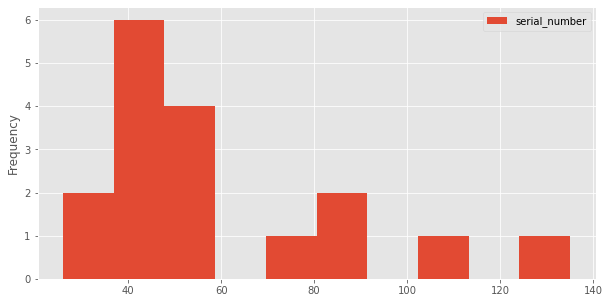

In [27]:
# Histogram of resample.
one_resample.plot(kind = "hist")

<AxesSubplot:ylabel='Frequency'>

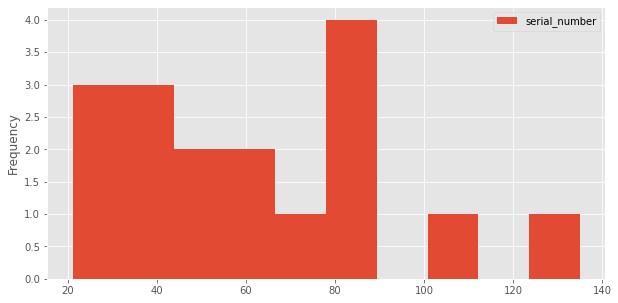

In [28]:
# Histogram of original sample.
observations.plot(kind = "hist")

**Question 2.3.** Which of the following are true:
1. In the plot of the resample, there are no bars at locations that weren't there in the plot of the original observations.
2. In the plot of the original observations, there are no bars at locations that weren't there in the plot of the resample.
3. There are no duplicate serial numbers in the resample.
4. There are no duplicate serial numbers in the original observations.

Assign `true_statements` to a list of the correct statements

In [29]:
true_statements = (1,4)

In [30]:
grader.check("q2_3")

q2_3 results: All test cases passed!

**Question 2.4.** Create 2 more resamples. For each resample, plot a histogram and compute the max-based and mean-based estimates using that resample.

Mean-based estimate for resample 1: 128.8235294117647
Max-based estimate for resample 1: 135


Mean-based estimate for resample 2: 106.82352941176471
Max-based estimate for resample 2: 108




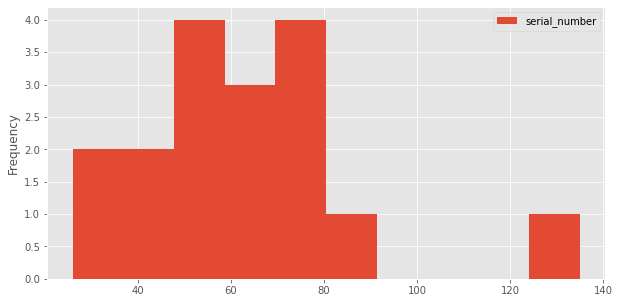

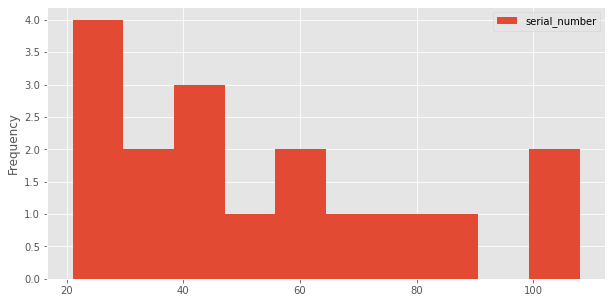

In [31]:
# np.arange(2) because we only want to create 2 resamples
for i in np.arange(2):
    resample = simulate_resample()
    
    # Plot a histogram of this resample
    resample.plot(kind = "hist")
    
    # Calculate the mean-based and max-based estimates based on this resample
    mean_based_estimate_resample = 2*(resample.get("serial_number").mean())
    max_based_estimate_resample = resample.get("serial_number").max()
    
    # Don't change the following 3 lines:
    print(f"Mean-based estimate for resample {i+1}:", mean_based_estimate_resample)
    print(f"Max-based estimate for resample {i+1}:", max_based_estimate_resample)
    print('\n')

There's a good chance that you'll find that the max-based estimates from the resamples are both exactly 135 (run the cell a few times and you'll almost surely see this happen). You'll also probably find that the two mean-based estimates differ from the sample mean-based estimate (and from each other).

**Question 2.5.** Compute the exact probability that a max-based estimate from one *resample* of our observations sample is 135 and assign it to the variable `resampling_q5` below. It may be useful to recall that the size of `observations` is 17.

Note that this is a **math** question, not a programming one. It may help to figure out your answer on paper and then assign `resampling_q5` to an expression that evaluates to the right answer.

_Hint:_ Think about the "grandma" example from Lecture 11. What is the probability that any one of the elements in our resample is equal to 135?

In [32]:
number_135 = observations[observations.get('serial_number')==135].shape[0]
p = number_135/17
resampling_q5 = 1-(1-p)**17
resampling_q5

0.6432138052537073

In [33]:
grader.check("q2_5")

q2_5 results: All test cases passed!

The correct answer is high, above 60%. Think about why a mean-based estimate from a resample is less likely to be exactly equal to the mean-based estimate from the original sample as compared to a max-based estimate.

## 3. Resampling via Simulation 💻

Since resampling from a large random sample looks just like sampling from a population, the code should look almost the same, too. That means we can write a function that simulates either sampling from a population or resampling from a sample.  If we pass it a population as its argument, it will do the former; if we pass it a sample, it will do the latter.

**Question 3.1.** Write a function called `simulate_estimates`. It should take 4 arguments:
- `original_df`: A DataFrame from which the data should be sampled, with 1 column named `'serial_number'`.
- `sample_size`: The size of each sample, an integer. (For example, to do resampling, we would pass the number of rows in `original_df` for this argument.)
- `statistic`: A **function** that computes a statistic on a sample. This argument is the **name of a function** that takes a Series of serial numbers as its argument and returns a number (e.g. `calculate_mean_based_estimate`).
- `repetitions`: The number of repetitions to perform (i.e. the number of resamples to create).

It should simulate `repetitions` samples **with replacement** from the given DataFrame. For each of those samples, it should compute the statistic on that sample. Then it should return an array containing the value of that statistic for each sample (this means that the length of the returned array should be equal to `repetitions`).

The code below provides an example use of your function and describes how you can verify that you've written it correctly.

***Check your answer***: The histogram you see should be a bell-shaped curve centered at 1000 with most of its mass in [800, 1200].

In [34]:
#for function put it outside not after.

In [35]:
#Put np.array inside or the next code dosent work. Always turn into an array early on

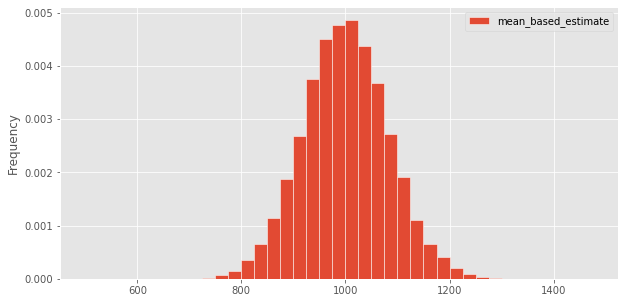

In [36]:
def simulate_estimates(original_df, sample_size, statistic, repetitions):
    vals = []
    for i in range(repetitions):
        x = statistic(original_df.get("serial_number").sample(sample_size, replace=True).values)
        vals.append(x)
    return np.array(vals)

#bootstrap_estimates = simulate_estimates(observations, observations.shape[0], mean_based_estimate_resample, 5000)


# This should generate an empirical histogram of twice-mean estimates
# of N from samples of size 50 if N is 1000.
# Notice that the statistic argument is calculate_mean_based_estimate.
example_estimates = simulate_estimates(
    bpd.DataFrame().assign(serial_number=np.arange(1, 1000+1)),
    50,
    calculate_mean_based_estimate,
    10000)
bpd.DataFrame().assign(mean_based_estimate = example_estimates).plot(kind = 'hist', density=True, bins=np.arange(500, 1500, 25), ec='w');

In [37]:
grader.check("q3_1")

q3_1 results: All test cases passed!

Now we can go back to the sample we actually observed (`observations`) and estimate how much our mean-based estimate of `N` would have varied from sample to sample.

**Question 3.2.** Using the bootstrap procedure and the sample `observations`, simulate the approximate distribution of **mean-based estimates** of `N`. Use 5,000 repetitions. Store the estimates in `bootstrap_estimates`. (Note that this only requires one line of code; call your `simulate_estimates` function.)

We have provided code that plots a histogram, allowing you to visualize the simulated estimates.

In [38]:
def mean_based_estimate_resample(sample):
    return 2 * sample.mean()

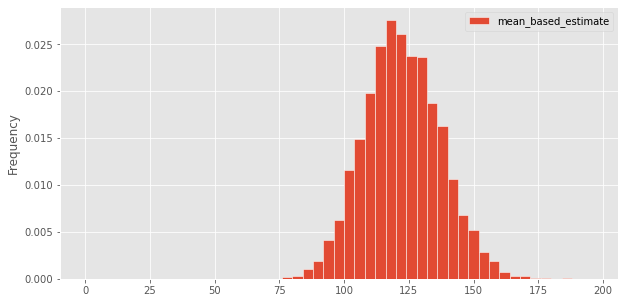

In [39]:
bootstrap_estimates = simulate_estimates(observations, observations.shape[0], mean_based_estimate_resample, 5000)
bpd.DataFrame().assign(mean_based_estimate = bootstrap_estimates).plot(kind = 'hist', density=True, bins=np.arange(0, 200, 4), ec='w');

In [40]:
grader.check("q3_2")

q3_2 results: All test cases passed!

**Question 3.3.** Compute an interval that covers the middle 95% of the bootstrap estimates.  Verify that your interval looks like it covers 95% of the area in the histogram above.


_Hints:_ 
- Use [`np.percentile`](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) here.
- If you find yourself using 5 and 95 as the arguments to `np.percentile`, try again – only 90% of the data is between the 5th and 95th percentiles!

In [41]:
left_end = np.percentile(bootstrap_estimates, 2.5)
right_end = np.percentile(bootstrap_estimates, 97.5)
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(left_end, right_end))

Middle 95% of bootstrap estimates: [94.941176, 152.005882]


In [42]:
grader.check("q3_3")

q3_3 results: All test cases passed!

**Question 3.4.** Let's say that `N`, the population parameter we've been trying to estimate, is actually 150. Write code that simulates the sampling and bootstrapping process again, as follows:

1. Generate a new set of random observations the Allies might have seen by sampling from the population DataFrame we have created for you below. Take a sample of size 70 **without replacement**. Store the sample in the variable name `new_observations`
2. Using only `new_observations` – not `population` – compute 5,000 bootstrapped mean-based estimates of `N`. To do this, call your  `simulate_estimates` function.
3. Compute an interval covering the middle 95% of these bootstrapped mean-based estimates.

In [43]:
population = bpd.DataFrame().assign(serial_number = np.arange(1, 150+1))
new_observations = population.sample(70, replace = False)
new_bootstrap_estimates =  simulate_estimates(new_observations, new_observations.shape[0], mean_based_estimate_resample, 5000)

new_left_end = np.percentile(new_bootstrap_estimates, 2.5)
new_right_end = np.percentile(new_bootstrap_estimates, 97.5)

print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(new_left_end, new_right_end))

Middle 95% of bootstrap estimates: [139.257143, 179.773571]


In [44]:
grader.check("q3_4")

q3_4 results: All test cases passed!

**Question 3.5.** If you ran your cell above many, many times, approximately what percentage of the intervals you created would include `N` (150 in this case)?  Assign either 1, 2, 3, 4, or 5 to the variable `simulating_q5` below.

1. 100%
2. 97.5%
3. 95%
4. 5%
5. It's impossible to tell.

In [45]:
simulating_q5 = 3

In [46]:
grader.check("q3_5")

q3_5 results: All test cases passed!

## 4. With or Without Replacement? 🔂

Each time we resampled from our original sample, we sampled **with replacement**. What would happen if we tried to resample without replacement? Let's find out!

Below, we will collect another random sample of size 70 from `population` that we can then resample from. We'll call it `original_sample`.

In [47]:
np.random.seed(23) # Magic so that you get the same result as us – don't change this line
original_sample = population.sample(70)
original_sample

,serial_number
139,140
125,126
67,68
3,4
113,114
...,...
53,54
76,77
132,133
114,115


**Question 4.1.** Below, 5,000 times, collect a resample of size 70 **from `original_sample` without replacement**. Compute the mean-based estimate on each resample, and store the estimates in the array `estimates_without_replacement`.

Note: You **cannot** use your `simulate_estimates` function here, because that samples with replacement. Instead, you'll have to write a new for-loop. It's a good idea to start by copying the code from your function in Question 3.1 and changing the necessary pieces.

In [48]:
def simulate_estimate(original_df, sample_size, statistic, repetitions):
    # Our implementation of this function took 4 to 5 short lines of code.
    vals = []
    for i in range(repetitions):
        x = statistic(np.array(original_df.get("serial_number").sample(sample_size)))
        vals.append(x)
    return np.array(vals)

estimates_without_replacement = simulate_estimate(original_sample, 70, mean_based_estimate_resample, 5000)
estimates_without_replacement

array([149.51428571, 149.51428571, 149.51428571, ..., 149.51428571,
       149.51428571, 149.51428571])

In [49]:
grader.check("q4_1")

q4_1 results: All test cases passed!

**Question 4.2.** If you completed 4.1 correctly, you'll notice that all 5,000 of your estimates are identical, and are equal to roughly 149.5143. Furthermore, this number is equal to the mean-based estimate derived from `original_sample`, without any resampling:

In [50]:
calculate_mean_based_estimate(original_sample.get('serial_number'))

149.5142857142857

Why are all of our estimates identical, and why **must** we sample with replacement when resampling?

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q4_2
manual: true
-->

They're all identical because when you dont replace them, you're pretty much getting the same values over and over again which isn't bootstrapping. The whole point is to be able to have repeats. Therefore, we must replace to have varying data sets.

<!-- END QUESTION -->



## Finish Line 🏁

Congratulations! You are done with Lab 5.

To submit your assignment:

1. Select `Kernel -> Restart & Run All` to ensure that you have executed all cells, including the test cells.
2. Read through the notebook to make sure everything is fine and all tests passed.
3. Run the cell below to run all tests, and make sure that they all pass.
4. Download your notebook using `File -> Download as -> Notebook (.ipynb)`, then upload your notebook to Gradescope.
5. Stick around while the Gradescope autograder grades your work. Make sure you see that all tests have passed on Gradescope.
6. Check that you have a confirmation email from Gradescope and save it as proof of your submission.

In [52]:
# For your convenience, you can run this cell to run all the tests at once!
grader.check_all()

q0_1 results: All test cases passed!

q0_2 results: All test cases passed!

q0_3 results: All test cases passed!

q1_1 results: All test cases passed!

q1_3 results: All test cases passed!

q1_4 results: All test cases passed!

q1_5 results: All test cases passed!

q2_1 results: All test cases passed!

q2_3 results: All test cases passed!

q2_5 results: All test cases passed!

q3_1 results: All test cases passed!

q3_2 results: All test cases passed!

q3_3 results: All test cases passed!

q3_4 results: All test cases passed!

q3_5 results: All test cases passed!

q4_1 results: All test cases passed!